### 问题建模
将对对联问题转化为序列标注问题。

### 训练语料
77w对对联数据/经过脱敏处理的70w对对联数据。

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torchtext.legacy.data import Field, Dataset, Example,BucketIterator,Iterator
from torchtext.vocab import Vectors

import os

from sklearn.metrics import f1_score,precision_score,recall_score

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim

from typing import List
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction



import unicodedata
import re
import codecs
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torchcrf import CRF

from tqdm import tqdm

import time
from torchtext.legacy.datasets import SequenceTaggingDataset
from ignite.metrics import RougeL

In [4]:
DEVICE=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED=2022
torch.manual_seed(SEED)

In [5]:
def load_sentences(path,p0='train',p1='in'):
    path=path+p0+'/'+p1+'.txt'
    text_list=[]
    for line in codecs.open(path, 'r', 'utf-8'):
        #drop the final dimension
        line=line.split(' ')[0:-1]
        text_list.append(line)
    return text_list

root_path='./data/couplet/'
para0=['train','test']
para1=['in','out']

train_in_sentences=load_sentences(root_path,'train','in')
train_out_sentences=load_sentences(root_path,'train','out')
test_in_sentences=load_sentences(root_path,'test','in')
test_out_sentences=load_sentences(root_path,'test','out')

assert len(train_in_sentences)==len(train_out_sentences)
assert len(test_in_sentences)==len(test_out_sentences)



In [6]:


def laod_dataset(sentence_in,sentence_out,textfield):

    len_sen=len(sentence_in)
    examples=[]
    fields = [('_in', textfield), ('_out', textfield)]
    for i in range(len_sen):
        examples.append(Example.fromlist([sentence_in[i], sentence_out[i]], fields))    
    dataset = Dataset(examples, fields)
    return dataset

TEXT=Field(sequential=True,use_vocab=True,include_lengths=True)

train_data=laod_dataset(train_in_sentences,train_out_sentences,textfield=TEXT)
valid_data=laod_dataset(test_in_sentences,test_out_sentences,textfield=TEXT)

BATCH_SIZE=128
vectors = Vectors(name='../data/sgns.sikuquanshu.word') 

TEXT.build_vocab(train_data,vectors=vectors)

train_iterator=BucketIterator(
    train_data,
    batch_size=BATCH_SIZE,
    device=DEVICE,
    sort_key=lambda x: len(x.TEXT)
)

valid_iterator=BucketIterator(
    valid_data,
    batch_size=BATCH_SIZE,
    device=DEVICE,
    sort_key=lambda x: len(x.TEXT)
)



### 模型
1. Embedding:用四库全书的预训练词向量。下载地址：https://github.com/Embedding/Chinese-Word-Vectors
2. 网络:双向LSTM
3. 输出：Linear

In [95]:
class BiLSTM(nn.Module):
    #定义模型中使用的所有层
    def __init__(self, vocab_size, embedding_dim=100, hidden_dim=120,):
        #构造函数
        super().__init__()
        #embeddding层
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        #lstm层
        self.lstm = nn.LSTM(embedding_dim, 
                           hidden_dim,
                           num_layers=1,
                           bidirectional=True, 

                           batch_first=True)
        self.fc = nn.Linear(hidden_dim*2, vocab_size)

    def forward(self, text,text_lengths):
        embedded=self.embedding(text) #添加了padding的embedding结果

        packed_embedded=pack_padded_sequence(embedded,text_lengths,batch_first=True,enforce_sorted=False)
        packed_output,_=self.lstm(packed_embedded) #没有padding的输出
        output,output_lengths=pad_packed_sequence(packed_output, batch_first=True) #返回输出，和没有padding的

        output=self.fc(output)
        return output


# class BiLSTMAttn(BiLSTM):
#     def __init__(self, vocab_size: int, embed_dim: int, hidden_dim: int, n_layer: int, embed_drop: float, rnn_drop: float, n_head: int):
#         super().__init__(vocab_size, embed_dim, hidden_dim, n_layer, embed_drop, rnn_drop)
#         self.attn = nn.MultiheadAttention(hidden_dim, n_head)

#     def forward(self, x, *args):
#         mask = args[0] if len(args) > 0 else None
#         x = self.encode(x)
#         x = x.transpose(0, 1)
#         x = self.attn(x, x, x, key_padding_mask=mask)[0].transpose(0, 1)
#         return self.predict(x)

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM=300
HIDDEN_DIM = 300

MODEL_NAME='BiLSTM'
model=BiLSTM(
    vocab_size=INPUT_DIM,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
     ).to(DEVICE)     


# Embedding set
pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

# dont no why use this ,set some vector to zero
# model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.requires_grad = True

#ignore the [PAD] index ,in pytorch is 1
criterion = nn.CrossEntropyLoss(ignore_index=1)
optimizer = optim.Adam(model.parameters(), lr=1e-3)



In [103]:
def categorical_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    max_preds = preds.argmax(dim = 1, keepdim = True) # get the index of the max probability
    correct = max_preds.squeeze(1).eq(y)
    correct=torch.tensor(correct.sum()).to(DEVICE)
    all=torch.tensor(y.shape[0]).to(DEVICE)
    return correct/ all




def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0  
    model.train() 
    for batch in tqdm(iterator):
        optimizer.zero_grad()
        text=batch._in[0]
        text=text.permute(1,0)
        text_lengths=batch._in[1].cpu()

        tags=batch._out[0]
        tags=tags.permute(1,0)
        predictions=model(text,text_lengths)


        # flatten to the form predict:[batch_size*sentence_length,vocab_size],tag:[batch_size*sentence_length. Dont use the BATCH_SIZE because the last batch.
        predictions=predictions.view(tags.shape[1]*tags.shape[0],-1)
        tags = tags.reshape(tags.shape[1]*tags.shape[0])
        acc = categorical_accuracy(predictions, tags)
        loss = criterion(predictions,tags)
        loss.backward()

        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in tqdm(iterator):

            text=batch._in[0]
            text=text.permute(1,0)
            text_lengths=batch._in[1].cpu()

            tags=batch._out[0]
            tags=tags.permute(1,0)
            predictions=model(text,text_lengths)


            # flatten to the form predict:[batch_size*sentence_length,vocab_size],tag:[batch_size*sentence_length. Dont use the BATCH_SIZE because the last batch.
            predictions=predictions.view(tags.shape[1]*tags.shape[0],-1)
            tags = tags.reshape(tags.shape[1]*tags.shape[0])
            acc = categorical_accuracy(predictions, tags)

            loss = criterion(predictions, tags)
                            
            acc = categorical_accuracy(predictions, tags)
          
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

  0%|          | 0/6020 [00:00<?, ?it/s]C:\Users\zoro\AppData\Local\Temp/ipykernel_4856/3269631090.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correct=torch.tensor(correct.sum()).to(DEVICE)
100%|██████████| 32/32 [00:00<00:00, 53.74it/s]


Epoch: 01 | Epoch Time: 5m 36s
	Train Loss: 5.163| Train PP: 174.64 | Train Acc: 5.62%
	 Val. Loss: 4.926| Val PP: 137.80 |  Val. Acc: 6.05%


100%|██████████| 32/32 [00:00<00:00, 47.83it/s]


Epoch: 02 | Epoch Time: 5m 40s
	Train Loss: 4.840| Train PP: 126.45 | Train Acc: 6.33%
	 Val. Loss: 4.870| Val PP: 130.33 |  Val. Acc: 6.35%


100%|██████████| 32/32 [00:00<00:00, 46.70it/s]


Epoch: 03 | Epoch Time: 5m 38s
	Train Loss: 4.720| Train PP: 112.22 | Train Acc: 6.62%
	 Val. Loss: 4.852| Val PP: 128.01 |  Val. Acc: 6.48%
![](./pic/BiLSTM-loss-3.jpg)


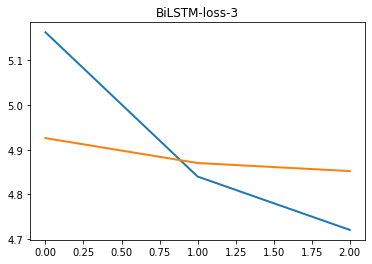

![](./pic/BiLSTM-acc-3.jpg)


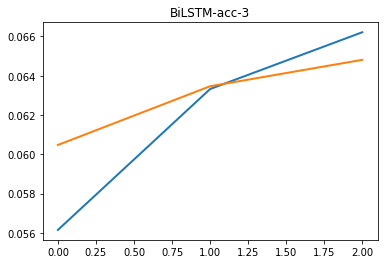

![](./pic/BiLSTM-PP-3.jpg)


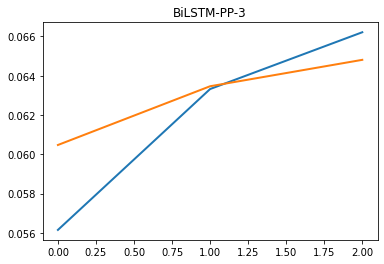

In [104]:
def trainmode():

    N_EPOCHS = 3
    best_valid_loss = float('inf')
    train_loss_list=[]
    valid_loss_list=[]
    train_acc_list=[]
    valid_acc_list=[]
    train_pp_list=[]
    valid_pp_list=[]

    for epoch in range(N_EPOCHS):

        start_time = time.time()
        
        train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
        valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

        train_pp=np.exp(train_loss)
        valid_pp=np.exp(valid_loss)
        
        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), './model/{}-model.pt'.format(MODEL_NAME))
        
        
        train_loss_list.append(train_loss)
        valid_loss_list.append(valid_loss)
        train_acc_list.append(train_acc)
        valid_acc_list.append(valid_acc)
        train_pp_list.append(train_pp)
        valid_pp_list.append(valid_pp)
        
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f}| Train PP: {train_pp:.2f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f}| Val PP: {valid_pp:.2f} |  Val. Acc: {valid_acc*100:.2f}%')


    def drawpic(train_loss_list=[],test_loss_list=[],epoch_number=10,title='1',root_path='./'):
        # make data
        x = [i for i in range(epoch_number)]
        # plot
        fig, ax = plt.subplots()
        plt.title(title)
        ax.plot(x, train_loss_list, linewidth=2.0)
        ax.plot(x, test_loss_list, linewidth=2.0)
        path=root_path+title+'.jpg'
        print('![]({})'.format(path))
        plt.savefig(path)
        plt.show()
    root_path='./pic/'
    title='{}-loss-{}'.format(MODEL_NAME,str(N_EPOCHS))

    drawpic(train_loss_list=train_loss_list,test_loss_list=valid_loss_list,epoch_number=N_EPOCHS,title=title,root_path=root_path)

    title='{}-acc-{}'.format(MODEL_NAME,str(N_EPOCHS))

    drawpic(train_loss_list=train_acc_list,test_loss_list=valid_acc_list,epoch_number=N_EPOCHS,title=title,root_path=root_path)

    title='{}-PP-{}'.format(MODEL_NAME,str(N_EPOCHS))

    drawpic(train_loss_list=train_acc_list,test_loss_list=valid_acc_list,epoch_number=N_EPOCHS,title=title,root_path=root_path)

trainmode()

In [1]:
model_gru=BiLSTM(
    vocab_size=INPUT_DIM,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
     ).to(DEVICE)   

model_gru.load_state_dict(torch.load('./model/{}-model.pt'.format(MODEL_NAME)))


In [ ]:
while 1:
    sentence=input('上联:')
    sen_list=list(sentence)
    sen_len=len(sen_list)

    indexed = [TEXT.vocab.stoi[t] for t in sen_list] 

    tensor = torch.LongTensor(indexed).to(DEVICE)              #转换为张量
    tensor = tensor.unsqueeze(1).T  

    prediction = model_gru(tensor)
    max_preds = prediction.argmax(dim = 2, keepdim = True)
    max_preds=max_preds.reshape(sen_len)
    sen_predict=[TEXT.vocab.itos[t] for t in max_preds]
    sen_predict=''.join(sen_predict)
    print('下联:',sentence)
